In [43]:
import pandas as pd
import traintools
from trainconstants import *
from collections import defaultdict
import networkx as nx
import itertools
from typing import List, Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

TrainStop = Tuple[int, int]

In [44]:
def highlight_paths(paths: List[List[TrainStop]], graph: nx.DiGraph):
    """
    """
    train_trips = nx.to_pandas_edgelist(graph)


    fig, ax = plt.subplots(figsize=(30, 10))

    for station in range(1, 5):
        plt.plot([300, 1440], [station, station], color='gray', alpha=0.4, linestyle="-", linewidth=5)

    for index, row in train_trips.iterrows():
        time = (row['source'][1], row['target'][1])
        stations = (row['source'][0], row['target'][0])
        plt.plot(time, stations, color='gray', linestyle='-', linewidth=2)
    
    colorcycle = itertools.cycle(traintools.colors)


    for path in paths:
        color = next(colorcycle)
        for index, current_stop in enumerate(path[:-1]):
            next_stop = path[index + 1]

            time = (current_stop[1], next_stop[1])
            stations = (current_stop[0], next_stop[0])
            plt.plot(time, stations, color=color, linestyle='-', linewidth=2)

    ax.text(300, AMSTERDAM + 0.1, 'Amsterdam', fontsize=15)
    ax.text(300, ROTTERDAM + 0.1, 'Rotterdam', fontsize=15)
    ax.text(300, ROOSENDAAL + 0.1, 'Roosendaal', fontsize=15)
    ax.text(300, VLISSINGEN + 0.1, 'Vlissingen', fontsize=15)

    stops_at_edges = tuple(itertools.chain(traintools.find_ending_trainstops(G), traintools.find_starting_trainstops(G)))

    y, x = zip(*stops_at_edges)
    plt.scatter(x, y, marker='d', s=50, c='r')
    ax.xaxis.set_ticklabels(range(300, 1500, 100))
    ax.set_xticks(range(300, 1500, 100))
    ax.set_xlim(250, 1450)
    ax.set_ylim(0.5, 4.5)
    ax.set_xlabel('Minutes past midnight')
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

In [45]:
def find_over_scheduled(G: nx.DiGraph) -> Tuple[int, defaultdict, defaultdict]:
    """Attempt at a solution where the end points don't need to be fixed.
    """

    def do_bookkeeping(path: List[TrainStop]) -> None:
        """Update the variables that keep track of the total number of trains 
        and where they start and end.
        """
        nonlocal all_trains, number_of_trains

        all_trains.append(path)
        number_of_trains += 1       


    def fix_start(node: TrainStop) -> None:
        """Add temp node to fix the starting point of the longest path.
        """
        nonlocal G
        G.add_edge('temp_start', node, over_scheduled=100)

    def fix_end(node: TrainStop) -> None:
        """Add temp node to fix ending point of the longest path.
        """
        nonlocal G
        G.add_edge(node, 'temp_end', over_scheduled=100)

    def remove_temp_start() -> None:
        """Remove temp node to get the 'true' graph back.
        """
        nonlocal G
        G.remove_node('temp_start')
        
    def remove_temp_end() -> None:
        """Remove temp node to get the 'true' graph back.
        """
        nonlocal G
        G.remove_node('temp_end')  

    starting_stops = {stop[0]: stop for stop in traintools.find_starting_trainstops(G)}
    ending_stops = {stop[0]: stop for stop in traintools.find_ending_trainstops(G)}

    # set up variables to keep track of the number of trains and at which stations the trains start and end.
    starting_trains, ending_trains, number_of_trains = defaultdict(list), defaultdict(list), 0
    all_trains = []

    ends, starts = traintools.find_ending_trainstops(G), traintools.find_starting_trainstops(G)
    for stop in ends:
        G.add_edge(stop, 'night', over_scheduled=100)

    for stop in starts:
        G.add_edge('morning', stop, over_scheduled=100)  

    # repeat until the longest path consists of only one node
    while nx.has_path(G, 'morning', 'night'):
        for i in range(1, 5):
            fix_start(starting_stops[i])
            fix_end(ending_stops[i])
            if nx.has_path(G, 'temp_start', 'temp_end'):
                path = nx.dag_longest_path(G, weight='over_scheduled') 

        do_bookkeeping(path)
        
        # go through the longest path and pick up the maximal number of passengers on the way
        for index, current_stop in enumerate(path[:-1]):
            next_stop = path[index + 1]
            G[current_stop][next_stop]['over_scheduled'] -= 1
    

        # recompute the longest path 
        to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['over_scheduled'] <= 0]
        G.remove_edges_from(to_remove)


    return(
        all_trains, 
        number_of_trains, 
        starting_trains, 
        ending_trains,
        G
        )

In [46]:
def attempt_solution_correct_endpoints(G: nx.DiGraph) -> Tuple[int, defaultdict, defaultdict]:
    """Attempt at a solution where the end points don't need to be fixed.
    """

    def do_bookkeeping(path: List[TrainStop]) -> None:
        """Update the variables that keep track of the total number of trains 
        and where they start and end.
        """
        nonlocal all_trains, starting_trains, ending_trains, number_of_trains

        all_trains.append(path)
        starting_trains[path[0][0]].append(path)
        ending_trains[path[-1][0]].append(path)
        number_of_trains += 1

    def fix_start(node: TrainStop) -> None:
        """Add temp node to fix the starting point of the longest path.
        """
        nonlocal G
        G.add_edge('temp_start', node, min_trains=100)

    def fix_end(node: TrainStop) -> None:
        """Add temp node to fix ending point of the longest path.
        """
        nonlocal G
        G.add_edge(node, 'temp_end', min_trains=100)

    def remove_temp_start() -> None:
        """Remove temp node to get the 'true' graph back.
        """
        nonlocal G
        G.remove_node('temp_start')
        
    def remove_temp_end() -> None:
        """Remove temp node to get the 'true' graph back.
        """
        nonlocal G
        G.remove_node('temp_end')  

    # find the end points of the graph
    ends, starts = traintools.find_ending_trainstops(G), traintools.find_starting_trainstops(G)

    # set up variables to keep track of the number of trains and at which stations the trains start and end
    starting_trains, ending_trains, number_of_trains = defaultdict(list), defaultdict(list), 0
    all_trains = []

    starting_stops = {stop[0]: stop for stop in traintools.find_starting_trainstops(G)}
    ending_stops = {stop[0]: stop for stop in traintools.find_ending_trainstops(G)}

    # find the longest path in the graph
    path = nx.dag_longest_path(G, weight='min_trains')    

    # repeat until the longest path consists of only one node
    next_random = False
    while G.size(weight='min_trains') > 0:

        do_bookkeeping(path)
        
        # go through the longest path and pick up the maximal number of passengers on the way
        for index, current_stop in enumerate(path[:-1]):
            next_stop = path[index + 1]
            G[current_stop][next_stop]['trains_scheduled'] += 1
            if G[current_stop][next_stop]['min_trains'] > 0:
                G[current_stop][next_stop]['min_trains'] -= 1
    

        # recompute the longest path 
        if next_random:
            path = nx.dag_longest_path(G, weight='min_trains')[1:-1]
            next_random = False
        else:
            prev_end = starting_stops[path[-1][0]]
            fix_start(prev_end)
            path = nx.dag_longest_path(G, weight='min_trains')[1:]
            fix_end(ending_stops[path[-1][0]])
            path = nx.dag_longest_path(G, weight='min_trains')[1:-1]
            remove_temp_end()
            remove_temp_start()  

        if nx.path_weight(G, path, weight='min_trains') == 0:
            next_random = True
        
    while stations_diff := Counter({station: len(trains) for station, trains in ending_trains.items()}) - Counter({station: len(trains) for station, trains in starting_trains.items()}):
        stations_diff2 = Counter({station: len(trains) for station, trains in starting_trains.items()}) - Counter({station: len(trains) for station, trains in ending_trains.items()})
        fix_start(starting_stops[stations_diff.most_common(1)[0][0]])
        fix_end(ending_stops[stations_diff2.most_common(1)[0][0]])
        path = nx.dag_longest_path(G, weight='min_trains')[1:-1]
        remove_temp_start()  
        remove_temp_end()

        do_bookkeeping(path)
        
    return(
        all_trains, 
        number_of_trains, 
        starting_trains, 
        ending_trains,
        G
        )

In [47]:
#visualize_graph(df_)
df = traintools.read_schedule("datasets/nsdata1.txt")
G = traintools.graph_from_schedule(df, TYPE_3_TRAIN)

all_trains, number_of_trains, starting_trains, ending_trains, G = attempt_solution_correct_endpoints(G.copy())
# print(all_trains)

print({station: len(trains) for station, trains in starting_trains.items()}, {station: len(trains) for station, trains in ending_trains.items()})
print('Endpoints match!'*({station: len(trains) for station, trains in starting_trains.items()} == {station: len(trains) for station, trains in ending_trains.items()}))

print('using:', number_of_trains)

df_ = nx.to_pandas_edgelist(G.copy())
df_['over_scheduled'] = df_['trains_scheduled'] - df_['trains_needed']
G_ = nx.from_pandas_edgelist(
        df=df_, 
        source='source', 
        target='target', 
        edge_attr=['over_scheduled'], 
        create_using=nx.DiGraph
        )
all_trains2, number_of_trains2, starting_trains2, ending_trains2, G2 = find_over_scheduled(G_)
print(number_of_trains2, 'train(s) can be subtracted')

{3: 5, 2: 7, 1: 3, 4: 10} {3: 5, 2: 7, 1: 3, 4: 10}
Endpoints match!
using: 25
3 train(s) can be subtracted


<ipython-input-44-8ff17fc206b8>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(300, 1500, 100))


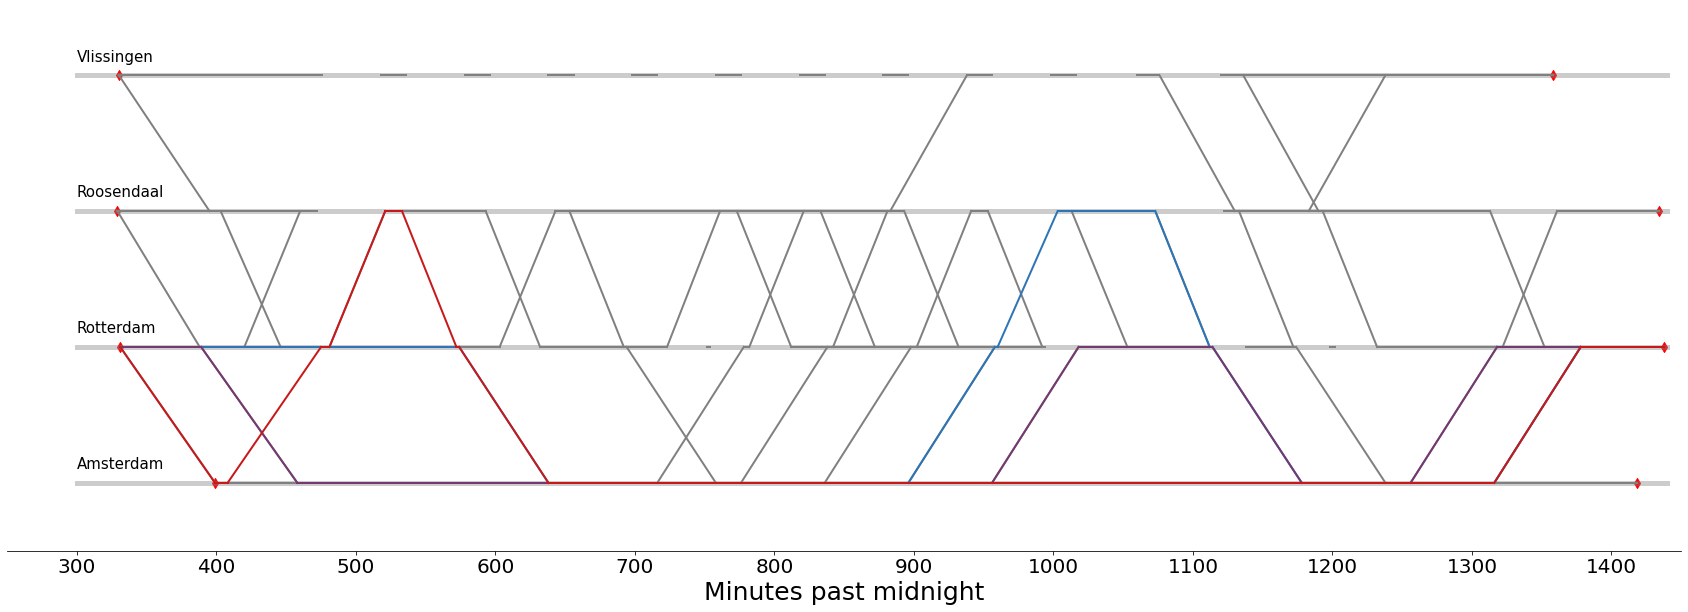

In [48]:

highlight_paths(all_trains2, G2)
#plt.savefig('test.svg')

<ipython-input-44-8ff17fc206b8>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(300, 1500, 100))


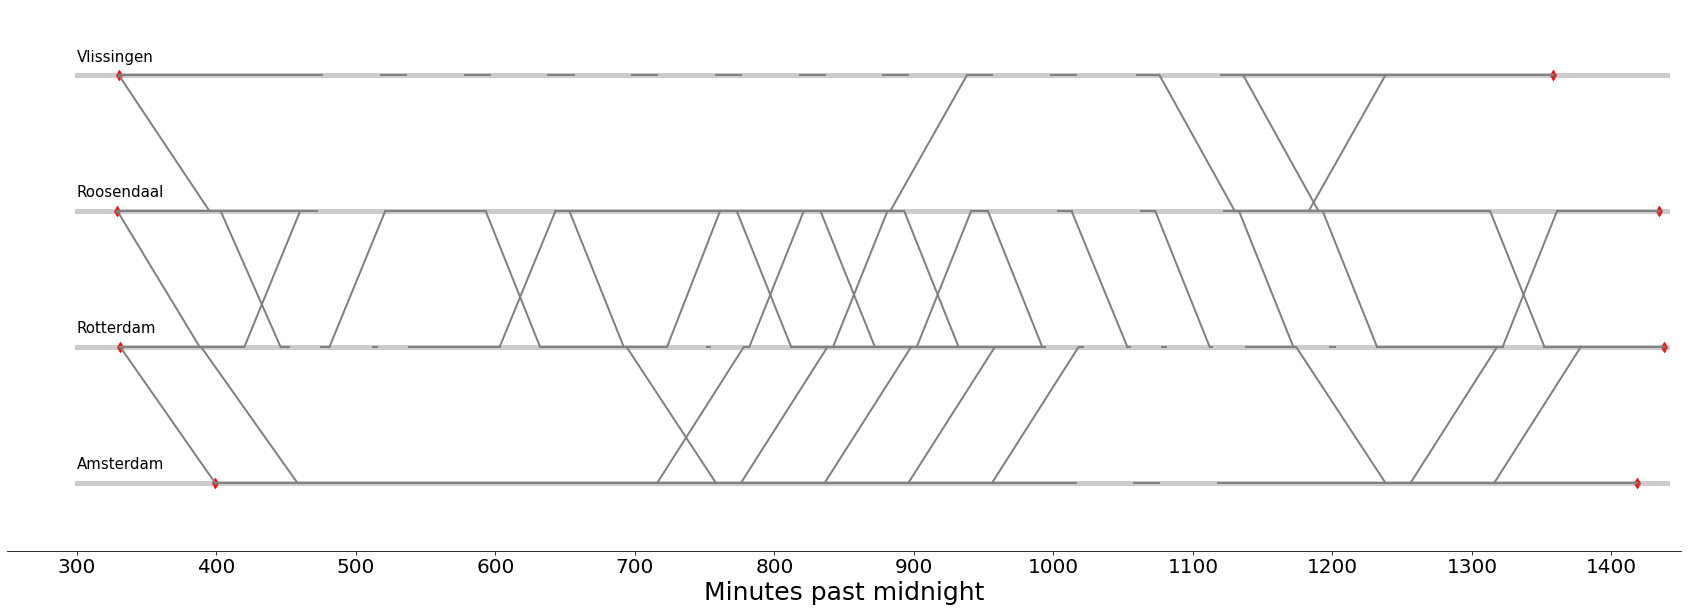

In [49]:
highlight_paths([], G2)